In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw


In [2]:
DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

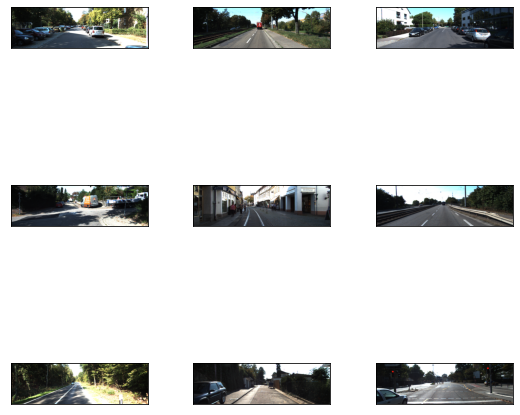

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.86, -1.6 ,  1.21,  1.81], dtype=float32)>, 'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.0027027 , 0.        , 0.45627028, 0.24818628],
       [0.41294596, 0.8101961 , 0.60191894, 0.8411846 ],
       [0.43359458, 0.3578513 , 0.537973  , 0.4207026 ],
       [0.47037837, 0.30758986, 0.53048646, 0.33875817]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[1.5 , 1.78, 3.69],
       [1.72, 0.78, 1.71],
       [1.51, 1.75, 4.45],
       [1.63, 1.78, 4.54]], dtype=float32)>, 'location': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ -3.16,   1.67,   3.35],
       [ 10.49,   0.9 ,  18.36],
       [ -5.57,   1.14,  30.17],
       [-16.13,   1.13,  54.72]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 0, 0])>, 'rotation_y': <tf.Tensor: shape=(4,

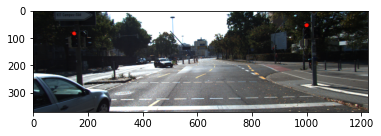

In [84]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

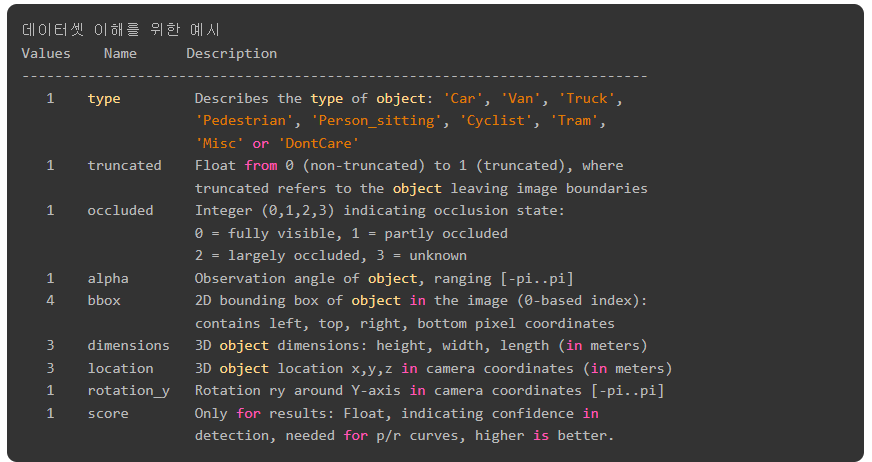

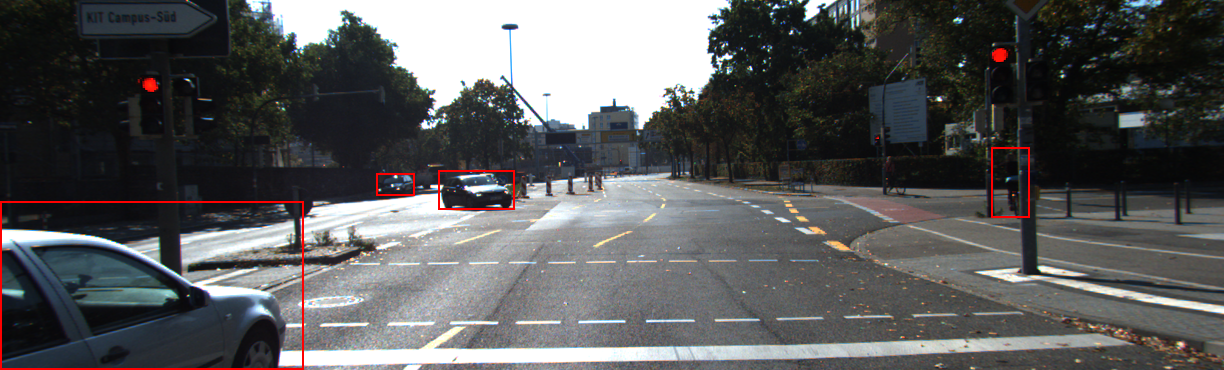

In [85]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image


visualize_bbox(img, objects['bbox'].numpy())

In [8]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [9]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

In [10]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

In [11]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [12]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

In [13]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [14]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [15]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

In [16]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [17]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [18]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [19]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [20]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss


In [21]:
# Define a custom MeanIoU metric
class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, name='mean_iou', **kwargs):
        super(MeanIoU, self).__init__(name=name, **kwargs)
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true: (batch_size, num_anchors, 5) - [box_target (4), cls_target (1)]
        # y_pred: (batch_size, num_anchors, 4 + num_classes)

        # Extract box predictions and ground truth boxes
        true_boxes = y_true[..., :4]
        pred_boxes = y_pred[..., :4]

        # Get mask of positive samples (where class label >= 0)
        positive_mask = tf.greater_equal(y_true[..., 4], 0.0)

        # Flatten the batch and num_anchors dimensions
        positive_mask = tf.reshape(positive_mask, [-1])
        true_boxes = tf.reshape(true_boxes, [-1, 4])
        pred_boxes = tf.reshape(pred_boxes, [-1, 4])

        # Filter out positive samples
        true_boxes = tf.boolean_mask(true_boxes, positive_mask)
        pred_boxes = tf.boolean_mask(pred_boxes, positive_mask)

        # Compute IoU
        iou = compute_iou_per_sample(true_boxes, pred_boxes)

        # Update total IoU and count
        num_positive = tf.cast(tf.size(iou), tf.float32)
        self.total_iou.assign_add(tf.reduce_sum(iou))
        self.count.assign_add(num_positive)

    def result(self):
        return tf.math.divide_no_nan(self.total_iou, self.count)

    def reset_states(self):
        self.total_iou.assign(0.0)
        self.count.assign(0.0)

# Helper function to compute IoU per sample
def compute_iou_per_sample(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, 0] * intersection[:, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = boxes1_area + boxes2_area - intersection_area
    iou = tf.math.divide_no_nan(intersection_area, union_area)
    return iou

In [22]:
def apply_nms(predictions, num_classes=8, max_output_size=100, iou_threshold=0.5, score_threshold=0.05):
    # predictions: (batch_size, num_anchors, 4 + num_classes)
    batch_size = tf.shape(predictions)[0]
    
    final_boxes = []
    final_scores = []
    final_labels = []
    
    # 배치의 각 이미지에 대해 반복
    for batch_index in range(batch_size):
        pred = predictions[batch_index]
        boxes = pred[:, :4]
        class_logits = pred[:, 4:]
        class_probs = tf.nn.sigmoid(class_logits)  # 로짓을 확률로 변환
        
        # 각 클래스에 대해 NMS 적용
        for class_id in range(num_classes):
            class_scores = class_probs[:, class_id]
            score_mask = class_scores > score_threshold
            scores = tf.boolean_mask(class_scores, score_mask)
            filtered_boxes = tf.boolean_mask(boxes, score_mask)
            
            if tf.shape(scores)[0] == 0:
                continue  # 남은 박스가 없으면 다음 클래스로
            
            selected_indices = tf.image.non_max_suppression(
                filtered_boxes,
                scores,
                max_output_size=max_output_size,
                iou_threshold=iou_threshold
            )
            selected_boxes = tf.gather(filtered_boxes, selected_indices)
            selected_scores = tf.gather(scores, selected_indices)
            selected_labels = tf.ones_like(selected_scores, dtype=tf.int32) * class_id  # 클래스 ID로 레이블 지정

            final_boxes.append(selected_boxes)
            final_scores.append(selected_scores)
            final_labels.append(selected_labels)
    
    # 모든 결과를 연결
    final_boxes = tf.concat(final_boxes, axis=0)
    final_scores = tf.concat(final_scores, axis=0)
    final_labels = tf.concat(final_labels, axis=0)
    
    return final_boxes, final_scores, final_labels

In [23]:
class MAPCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, num_classes=8):
        super(MAPCallback, self).__init__()
        self.val_dataset = val_dataset
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        total_true_positives = 0
        total_false_positives = 0
        total_false_negatives = 0

        for images, labels in self.val_dataset:
            # 모델 예측 얻기
            predictions = self.model(images, training=False)

            # NMS 적용
            pred_boxes, pred_scores, pred_labels = apply_nms(predictions, num_classes=self.num_classes)

            # 실제 박스와 라벨 추출
            true_boxes = labels[..., :4]
            true_labels = labels[..., 4]

            # 유효한 라벨 필터링 (라벨 >= 0)
            valid_mask = true_labels >= 0
            true_boxes = tf.boolean_mask(true_boxes, valid_mask)
            true_labels = tf.boolean_mask(true_labels, valid_mask)
            true_labels = tf.cast(true_labels, tf.int32)

            # 메트릭 계산
            tp, fp, fn = compute_metrics(pred_boxes, pred_scores, pred_labels, true_boxes, true_labels, num_classes=self.num_classes)
            total_true_positives += tp
            total_false_positives += fp
            total_false_negatives += fn

        # total_* 변수를 float32로 캐스팅
        total_true_positives = tf.cast(total_true_positives, tf.float32)
        total_false_positives = tf.cast(total_false_positives, tf.float32)
        total_false_negatives = tf.cast(total_false_negatives, tf.float32)

        # 정밀도와 재현율 계산
        precision = total_true_positives / (total_true_positives + total_false_positives + 1e-8)
        recall = total_true_positives / (total_true_positives + total_false_negatives + 1e-8)

        # mAP 계산
        mAP = compute_mean_average_precision(precision, recall)

        # mAP 출력
        print(f"\nEpoch {epoch + 1}: mAP: {mAP:.4f}")
        logs['mAP'] = mAP

In [24]:
def compute_metrics(pred_boxes, pred_scores, pred_labels, true_boxes, true_labels, num_classes=8, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # 실제 박스와 라벨을 클래스별로 분리
    for class_id in range(num_classes):
        # 예측된 박스와 스코어에서 해당 클래스의 것만 선택
        pred_mask = tf.equal(pred_labels, class_id)
        pred_boxes_c = tf.boolean_mask(pred_boxes, pred_mask)
        pred_scores_c = tf.boolean_mask(pred_scores, pred_mask)

        # 실제 박스에서 해당 클래스의 것만 선택
        true_mask = tf.equal(true_labels, class_id)
        true_boxes_c = tf.boolean_mask(true_boxes, true_mask)

        # 만약 실제 박스가 없으면, 모든 예측은 거짓 양성
        if tf.shape(true_boxes_c)[0] == 0:
            false_positives += tf.shape(pred_boxes_c)[0]
            continue

        # 만약 예측된 박스가 없으면, 모든 실제 박스는 거짓 음성
        if tf.shape(pred_boxes_c)[0] == 0:
            false_negatives += tf.shape(true_boxes_c)[0]
            continue

        # IoU 계산
        iou_matrix = compute_iou(pred_boxes_c, true_boxes_c)

        # 예측과 실제 박스 매칭
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        match_mask = max_iou >= iou_threshold

        true_positives += tf.reduce_sum(tf.cast(match_mask, tf.int32))
        false_positives += tf.shape(pred_boxes_c)[0] - tf.reduce_sum(tf.cast(match_mask, tf.int32))
        false_negatives += tf.shape(true_boxes_c)[0] - tf.reduce_sum(tf.cast(match_mask, tf.int32))

    return true_positives, false_positives, false_negatives

In [25]:
def compute_mean_average_precision(precision, recall):
    # 간단히 정밀도와 재현율의 평균을 사용
    return (precision + recall) / 2.0

In [26]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

94781440/94765736 [==============================] - 0s 0us/step


In [27]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=[MeanIoU()])

In [28]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [76]:
model.summary()

Model: "RetinaNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeaturePyramid (FeaturePyram multiple                  31585152  
_________________________________________________________________
sequential (Sequential)      (None, None, None, 72)    2526280   
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 36)    2443300   
Total params: 36,554,732
Trainable params: 36,501,612
Non-trainable params: 53,120
_________________________________________________________________


In [29]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/checkpoints/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    ),
    MAPCallback(val_dataset, num_classes=num_classes) 
]
epochs = 20

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/20
3173/3173 [==============================] - ETA: 0s - loss: 2.1855 - mean_iou: 0.0088

/opt/conda/lib/python3.9/site-packages/keras/metrics.py:254: UserWarning: Metric MeanIoU implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


3173/3173 [==============================] - 1626s 507ms/step - loss: 2.1855 - mean_iou: 0.0088 - val_loss: 1.4966 - val_mean_iou: 0.0123

Epoch 00001: saving model to /aiffel/aiffel/object_detection/checkpoints/weights_epoch_1

Epoch 1: mAP: 0.0046
Epoch 2/20
3173/3173 [==============================] - 1610s 507ms/step - loss: 0.9880 - mean_iou: 0.0261 - val_loss: 1.3090 - val_mean_iou: 0.0198

Epoch 00002: saving model to /aiffel/aiffel/object_detection/checkpoints/weights_epoch_2

Epoch 2: mAP: 0.0064
Epoch 3/20
3173/3173 [==============================] - 1610s 507ms/step - loss: 0.7186 - mean_iou: 0.0363 - val_loss: 1.0992 - val_mean_iou: 0.0225

Epoch 00003: saving model to /aiffel/aiffel/object_detection/checkpoints/weights_epoch_3

Epoch 3: mAP: 0.0073
Epoch 4/20
3173/3173 [==============================] - 1610s 507ms/step - loss: 0.5762 - mean_iou: 0.0431 - val_loss: 1.0268 - val_mean_iou: 0.0286

Epoch 00004: saving model to /aiffel/aiffel/object_detection/checkpoints/weigh

In [95]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [96]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [97]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

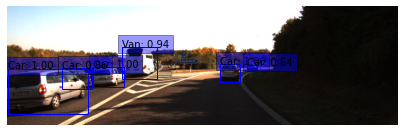

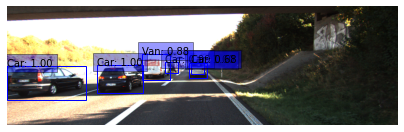

In [98]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

int2str = dataset_info.features["objects"]["type"].int2str
sample = ds_test.take(2)
for sample in sample:
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

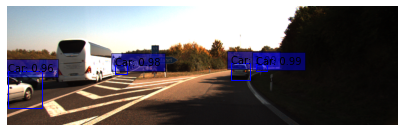

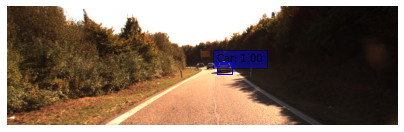

In [99]:
model_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'object_detection', 'checkpoints')
checkpoint_path = os.path.join(model_dir, 'weights_epoch_16')
model.load_weights(checkpoint_path)

image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

int2str = dataset_info.features["objects"]["type"].int2str
sample = ds_test.take(2)
for sample in sample:
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

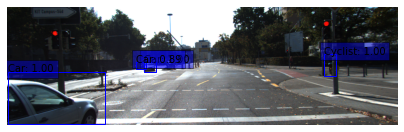

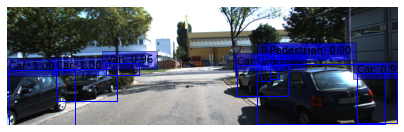

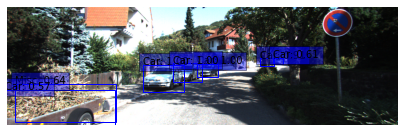

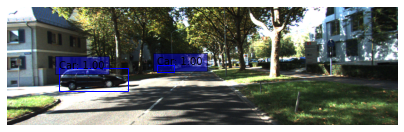

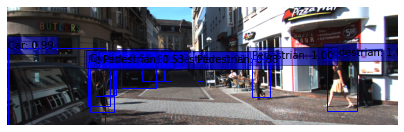

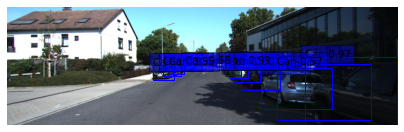

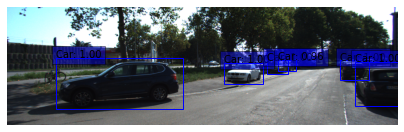

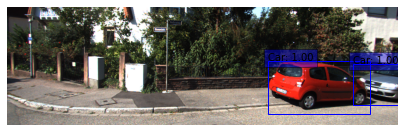

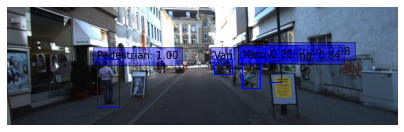

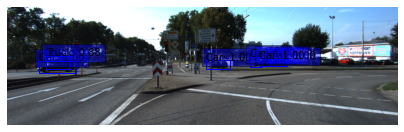

In [100]:
model_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'object_detection', 'checkpoints')
checkpoint_path = os.path.join(model_dir, 'weights_epoch_16')
model.load_weights(checkpoint_path)

image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

int2str = dataset_info.features["objects"]["type"].int2str
sample = ds_train.take(10)
for sample in sample:
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

In [117]:
def self_drive_assist(img_path, size_limit=300,is_visual=False):
    # Load and preprocess the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    ratio = ratio.numpy()
    
    detections = inference_model(input_image)
    num_detections = int(detections.valid_detections[0])
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    classes = detections.nmsed_classes[0][:num_detections].numpy().astype(int)
    scores = detections.nmsed_scores[0][:num_detections].numpy()
    
    class_id_to_name = {
        0: 'Car',
        1: 'Van',
        2: 'Truck',
        3: 'Pedestrian',
        4: 'Person_sitting',
        5: 'Cyclist',
        6: 'Tram',
        7: 'Misc'
    }
    class_names = [class_id_to_name.get(cls, 'Unknown') for cls in classes]
    
    if is_visual == True:
        visualize_detections(
            image,
            detections.nmsed_boxes[0][:num_detections] / ratio,
            class_names,
            detections.nmsed_scores[0][:num_detections],
        )
    
    for i in range(num_detections):
        class_name = class_names[i]
        box = boxes[i]
        x1, y1, x2, y2 = box 
        width = x2 - x1
        height = y2 - y1

        if class_name in ["Pedestrian", "Person_sitting", "Cyclist"]:
            return "Stop"
        elif class_name in ["Car", "Van", "Truck", "Tram"]:
            if width >= size_limit or height >= size_limit:
                return "Stop"
    
    return "Go"

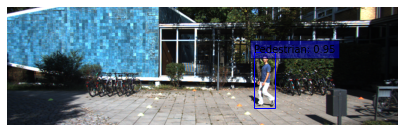

Stop


In [118]:
model_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'object_detection', 'checkpoints')
checkpoint_path = os.path.join(model_dir, 'weights_epoch_5')
model.load_weights(checkpoint_path)

img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'
print(self_drive_assist(img_path,is_visual=True))

In [120]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

100점입니다.


In [129]:
model_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'object_detection', 'checkpoints')
checkpoint_path = os.path.join(model_dir, 'weights_epoch_1')
model.load_weights(checkpoint_path)

test_system(self_drive_assist)

80점입니다.


In [133]:
model_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'object_detection', 'checkpoints')
checkpoint_path = os.path.join(model_dir, 'weights_epoch_5')
model.load_weights(checkpoint_path)

test_system(self_drive_assist)

100점입니다.


In [130]:
model_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'object_detection', 'checkpoints')
checkpoint_path = os.path.join(model_dir, 'weights_epoch_16')
model.load_weights(checkpoint_path)

test_system(self_drive_assist)

90점입니다.


In [131]:
model_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'object_detection', 'checkpoints')
checkpoint_path = os.path.join(model_dir, 'weights_epoch_20')
model.load_weights(checkpoint_path)

test_system(self_drive_assist)

90점입니다.
